#Week1 

This weeek's tutorial provides an introduction into data dimensionality. It contains no exercises as the reader is encouraged to alter the data according to his own questions

#Curse of Dimensionality. Dimensionality reduction. PCA. ZCA

In [1]:
## to view 3D scatterplots in a new window (and be able to rotate the plot),
## restart this notebook, comment the next line, uncomment the following one and then run this cell
%pylab inline
#from pylab import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
import numpy as np
import scipy as sp
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import RandomizedPCA

from sklearn import neighbors
from sklearn import covariance
from sklearn import manifold
from sklearn import mixture

from calc_tsne import calc_tsne

In [3]:
def zca_whitening(X, epsilon=1e-3):
    
    X = X - sp.mean(X, axis = 0)
    cov = sp.dot(X.T, X) / X.shape[0]
    U, D, V = sp.linalg.svd(cov, )
    x_rot = sp.dot(X, U)
    x_hat = sp.dot(x_rot[:, :1], U[:, :1].T)
    x_pca_white = x_rot * (1./ sp.sqrt(D + epsilon))[sp.newaxis, :]
    x_zca_white = sp.dot(x_pca_white, U.T) 
    
    return x_zca_white

def compute_rpca(X):
    
    scores = []
    clf = RandomizedPCA(n_components=1)
    clf.fit(X)
    Q = clf.components_.T
    # computing the normal subspace
    P = np.dot(Q, Q.T)
    for idx in range(X.shape[0]):
        # "distance" to normal subspace
        y_norm = np.linalg.norm(X[idx]-np.dot(P, X[idx]))
        # "distance" to anomalies subspace
        y_out = np.linalg.norm(X[idx]-np.dot(1-P, X[idx]))
        scores.append((idx, y_norm, y_out))
        
    return np.array((scores))

Let's generate some data. That is 4 clusters, with various means and variances, each having n_samples.


In [4]:
n_samples = 200
C = np.array([[0.9, -9.1], [1.1, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C) + np.array([4, 27]),
          .97 * np.random.randn(n_samples, 2) + np.array([6, 57]), 
          .17 * np.random.randn(n_samples, 2) + np.array([2., 57]), 
          .67 * np.random.randn(n_samples, 2) + np.array([2., 0])]

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


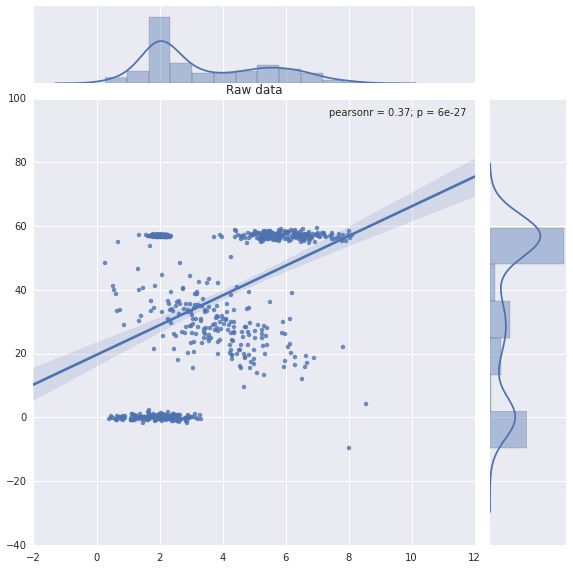

In [5]:
j = sns.jointplot(X[:, 0], X[:, 1], kind='reg', size=8)
t = title('Raw data')

## Preprocessing data

Let's scale and whiten the data.

$$
\Sigma = \frac{1}{m}\sum_{i=1}^{m}(x^i)(x^i)^T
$$
$\Sigma$ is the covariance matrix iff x has zero mean.

In [6]:
X = X - sp.mean(X, axis = 0)
cov = sp.dot(X.T, X) / X.shape[0]
print cov.shape

(2, 2)


The result of PCA is a PC matrix $U$, where each column vector represents the new basis in the PC transformation. And thus the transformed new $x_{rot}$ can be represented as $U^Tx$. The subscript "rot" comes from the observation that the PCA transformation corresponds to a rotation, iff the mean of the original data is zero.
- One of the properties of the PCA matrix $U$ is that it is an "orthogonal" matrix (which consists of an orthogonal basis), i.e., $U^TU=UU^T=I$, which means you can rotate back from $x_{rot}$ to original $x$ by the same transpose matrix $x = Ux_{rot}$;

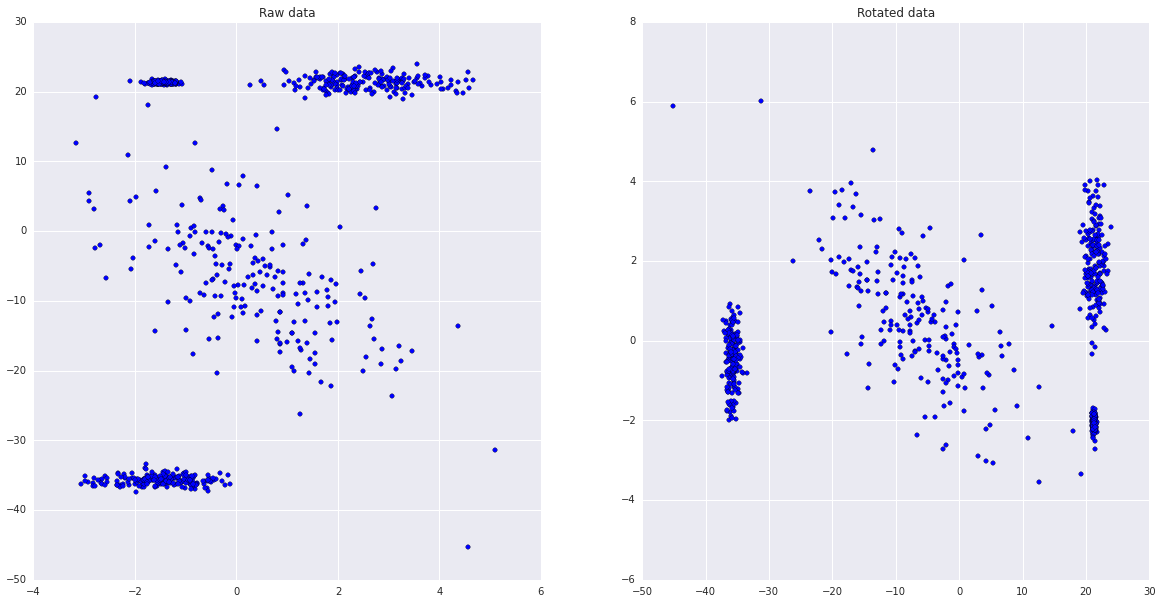

In [7]:
U, D, V = sp.linalg.svd(cov, )
x_rot = sp.dot(X, U)

figure(figsize(20,10))
subplot(1, 2, 1).scatter(X[:, 0], X[:, 1], cmap="cool")
t = title("Raw data")
subplot(1, 2, 2).scatter(x_rot[:, 0], x_rot[:, 1], cmap="cool")
t = title("Rotated data")

- Using PCA to reduce data dimension and approximate data: this is done by first transforming data into PC basis, discarding the rest n-k insignificant components, and 'rotate back' to original basis;

- to decide how to set k, we usually look at the percentage of variance retained for different values of k, and for retaining k PCs, the percentage of variance retained is given by
$$
\frac{\sum_{j=1}^{k}\lambda_{j}}{\sum_{j=1}^{n}\lambda_{j}}
$$

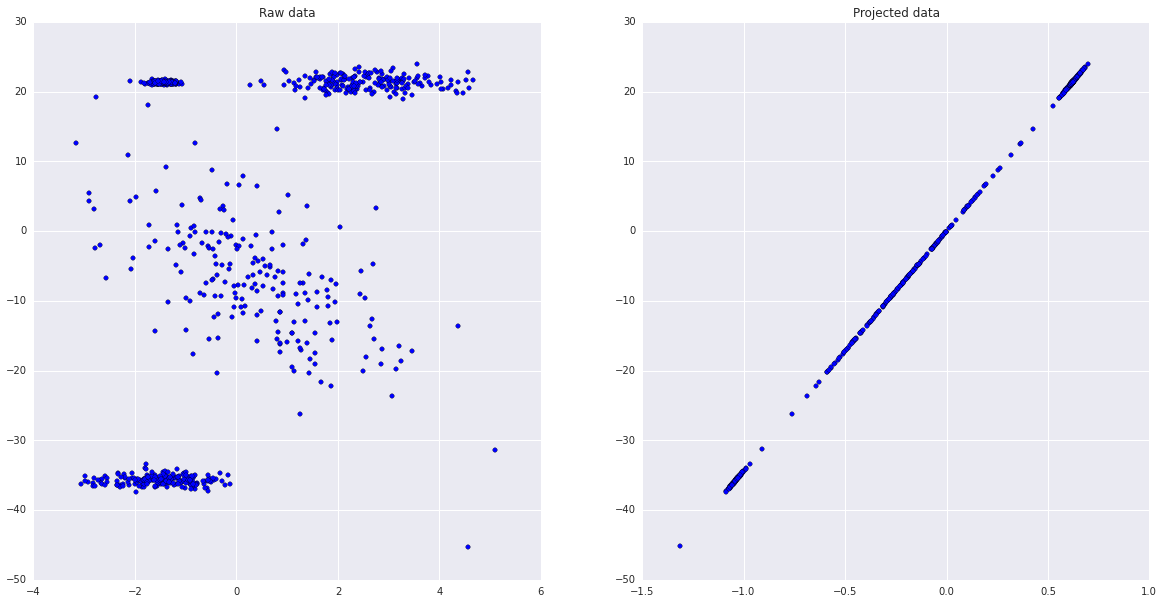

In [8]:
x_hat = sp.dot(x_rot[:, :1], U[:, :1].T)

figure(figsize(20,10))
subplot(1, 2, 1).scatter(X[:, 0], X[:, 1], cmap="cool")
t = title("Raw data")
subplot(1, 2, 2).scatter(x_hat[:, 0], x_hat[:, 1], cmap="cool")
t = title("Projected data")

- **PCA Whitening** can be represented as
$$
x_{PCAwhitel,i} = \frac{x_{rot,i}}{\sqrt{\lambda_i}}
$$
Similar to using PCA alone, PCA with whitening also results in processed data that has a diagonal covariance matrix. However, unlike PCA alone, whitening additionally ensures that the diagonal entries are equal to 1, i.e. that the covariance matrix is the identity matrix;

- **implementation details**: When implementing PCA whitening or ZCA whitening in practice, sometimes some of the eigenvalues  $\lambda_i$ will be numerically close to 0, and thus the scaling step where we divide by $\sqrt{\lambda_i}$ would involve dividing by a value close to zero; this may cause the data to blow up (take on large values) or otherwise be numerically unstable. In practice, we therefore implement this scaling step using a small amount of regularization, and add a small constant  $\epsilon$ to the eigenvalues before taking their square root and inverse:
$$
\begin{align}
x_{{\rm PCAwhite},i} = \frac{x_{{\rm rot},i} }{\sqrt{\lambda_i + \epsilon}}.
\end{align}
$$
When $x$ takes values around $[-1,1]$, a value of $\textstyle \epsilon \approx 10^{-5}$ might be typical.

[[  9.99998269e-01  -5.32907052e-17]
 [ -5.32907052e-17   9.99676971e-01]]
Close resemblance to identity matrix


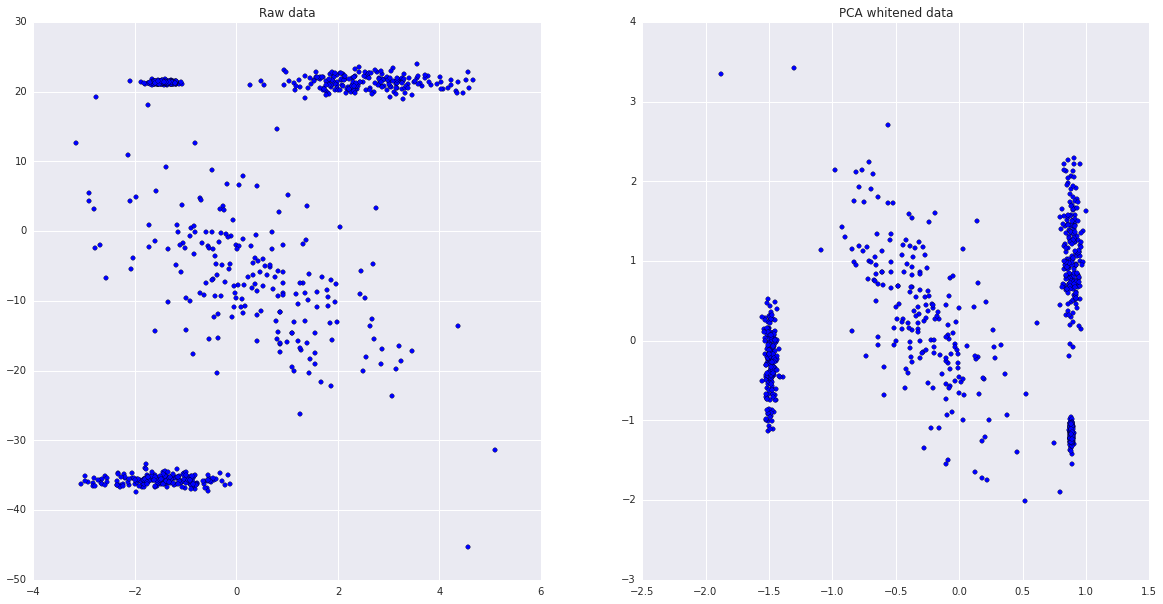

In [9]:
x_pca_white = x_rot * (1./ sp.sqrt(D + 1e-3))[sp.newaxis, :]
cov_pca = sp.dot(x_pca_white.T, x_pca_white) / x_pca_white.shape[0]
print cov_pca
print 'Close resemblance to identity matrix'

figure(figsize(20,10))
subplot(1, 2, 1).scatter(X[:, 0], X[:, 1], cmap="cool")
t = title("Raw data")
subplot(1, 2, 2).scatter(x_pca_white[:, 0], x_pca_white[:, 1], cmap="cool")
t = title("PCA whitened data")

- **ZCA Whitening** since PCA matrix $U$ is orthogonal, rotating back the PCA-whitened features will have the property of having an identity $I$ as covariance matrix. So
$$
x_{ZCAwhite} = Ux_{PCAwhite}
$$
Compared to PCA whitening, ZCA-whitening has the property that the transformed features have the as close as possible values to the original input. And unlike PCA whitening, which is usually done with a dimension reduction, ZCA whitening is usually used while keeping all n dimensions of data

[[  9.99677243e-01   9.33638329e-06]
 [  9.33638329e-06   9.99997997e-01]]


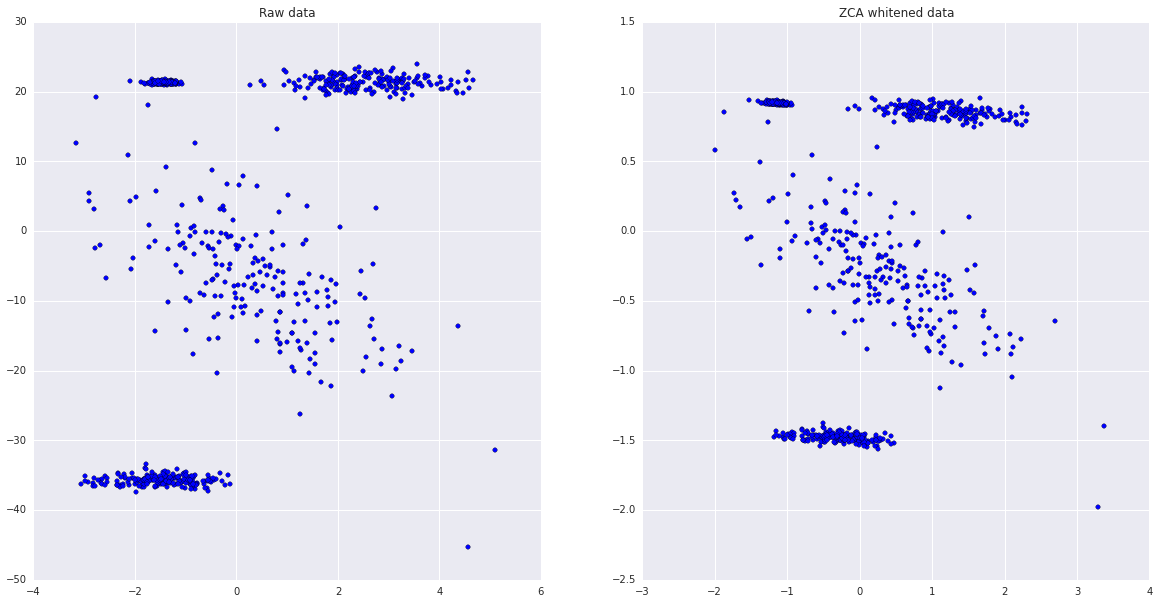

In [10]:
x_zca_white = sp.dot(x_pca_white, U.T)
cov_zca = sp.dot(x_zca_white.T, x_zca_white) / x_zca_white.shape[0]
print cov_zca

figure(figsize(20,10))
subplot(1, 2, 1).scatter(X[:, 0], X[:, 1], cmap="cool")
t = title("Raw data")
subplot(1, 2, 2).scatter(x_zca_white[:, 0], x_zca_white[:, 1], cmap="cool")
t = title("ZCA whitened data")

In [11]:
def zca_whitening(X, epsilon=1e-3):
    
    X = X - sp.mean(X, axis = 0)
    cov = sp.dot(X.T, X) / X.shape[0]
    U, D, V = sp.linalg.svd(cov, )
    x_rot = sp.dot(X, U)
    x_hat = sp.dot(x_rot[:, :1], U[:, :1].T)
    x_pca_white = x_rot * (1./ sp.sqrt(D + epsilon))[sp.newaxis, :]
    x_zca_white = sp.dot(x_pca_white, U.T) 
    
    return x_zca_white

In [12]:
X_white = zca_whitening(X)

In [13]:
ss = StandardScaler()
X_ss = ss.fit_transform(X)

figure(figsize(20,10))
subplot(1, 2, 1).scatter(x_zca_white[:, 0], x_zca_white[:, 1], cmap="cool")
t = title("ZCA whitened data")
subplot(1, 2, 2).scatter(X_ss[:, 0], X_ss[:, 1], cmap="cool")
t = title("Standardized data")

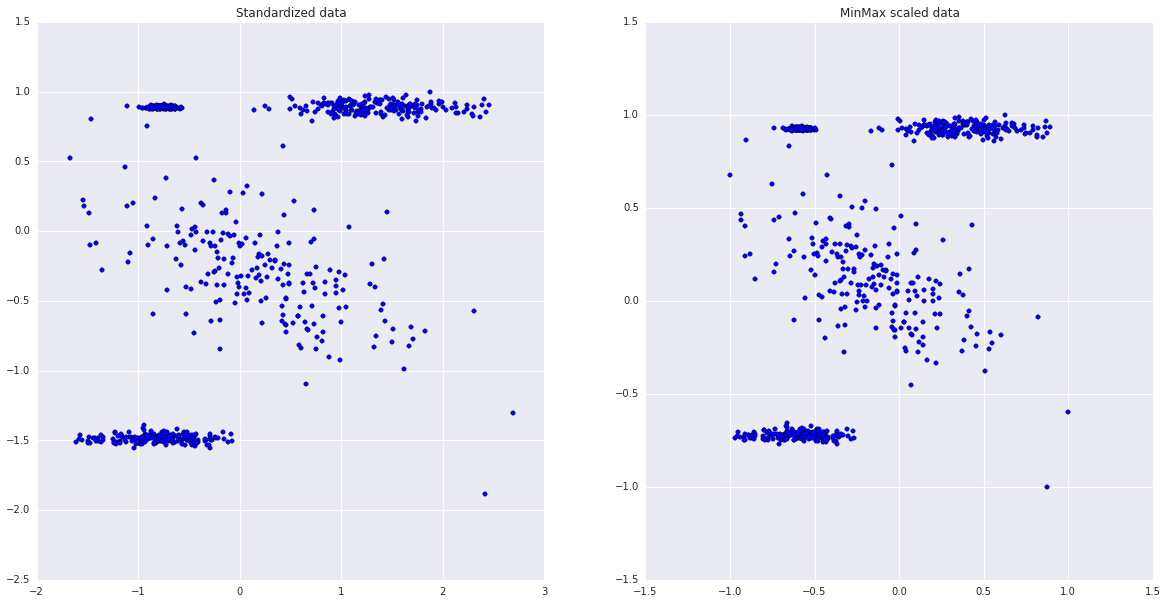

In [14]:
mms = MinMaxScaler((-1, 1))
X_mms = mms.fit_transform(X)

figure(figsize(20,10))
subplot(1, 2, 1).scatter(X_ss[:, 0], X_ss[:, 1], cmap="cool")
t = title("Standardized data")
subplot(1, 2, 2).scatter(X_mms[:, 0], X_mms[:, 1], cmap="cool")
t = title("MinMax scaled data")

## Embedding/Manifold learning

Manifold Learning can be thought of as an attempt to generalize linear frameworks like PCA to be sensitive to non-linear structure in data.

In [15]:
def plot_3d(X, labels):
    
    fig = plt.figure(1)
    fig.clf()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=labels, c=labels, cmap='cool')
    plt.show()

Let's generate a different set of data

In [16]:
n_samples = 200
x_range = np.linspace(3, 70, n_samples)
y_range = np.linspace(1, 12, 3)

# create arrays x,y,z in the correct dimensions
# so that they create the grid
x,y = np.ix_(x_range,y_range)

k=160

C = np.array([[0.9, -9.1, .06], [1.1, .4, 1.], [1.0, -.4, .5]])
Y = np.r_[np.dot(np.random.randn(n_samples, 3), C) + np.array([4, 27, 15]),
          .97 * np.random.randn(n_samples, 3) + np.array([8, 30, 12]), 
          .17 * np.random.randn(n_samples, 3) + np.array([2., 20, 21]), 
          .67 * np.random.randn(n_samples, 3) + np.array([2., 0, 12]), 
          7*np.sin(x+y) + np.array([2., 30, 12])]

Y_white = zca_whitening(Y)

ss = StandardScaler()
Y_ss = ss.fit_transform(Y)

mms = MinMaxScaler((-1, 1))
Y_mms = mms.fit_transform(Y)

First let's define a function for anomaly detection to see how it changes under different manifold transformations

In [17]:
def compute_lof(X, k):
    
    clf = neighbors.NearestNeighbors(leaf_size=30, metric='euclidean', algorithm='brute')
    clf.fit(X)
    dist, indices = clf.kneighbors(X, k+1)
    dx, idx_knn = dist[:, 1:], indices[:, 1:]
    radius = dx[:, -1]
    LRD = np.mean(np.maximum(dx, radius[idx_knn]), axis = 1)
    rho = 1./ LRD
    score = np.sum(rho[idx_knn], axis = 1)/ np.array(rho, dtype = np.float16)
    score *= 1./k
    
    tmp_score = score.copy()
    tmp_score[np.where(np.isinf(tmp_score))]=0.5
    tmp_score[np.where(np.isnan(tmp_score))]=0.5
    
    score[np.where(np.isinf(score))]=tmp_score.max()
    score[np.where(np.isnan(score))]=tmp_score.max()
    
    return score, clf

In [18]:
score, _ = compute_lof(Y, 120)
score /= score.max()

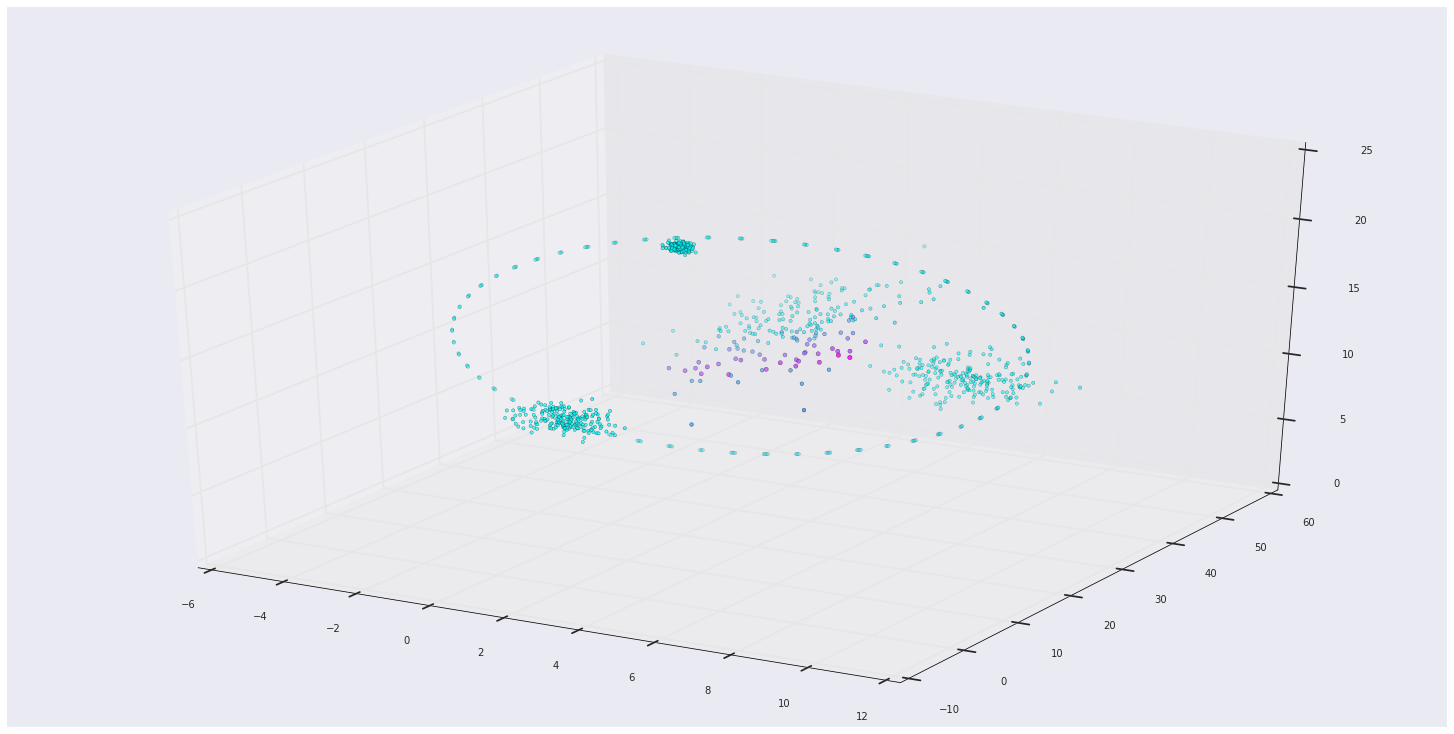

In [19]:
plot_3d(Y, (score+1)*10)

### Isomap

Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points.

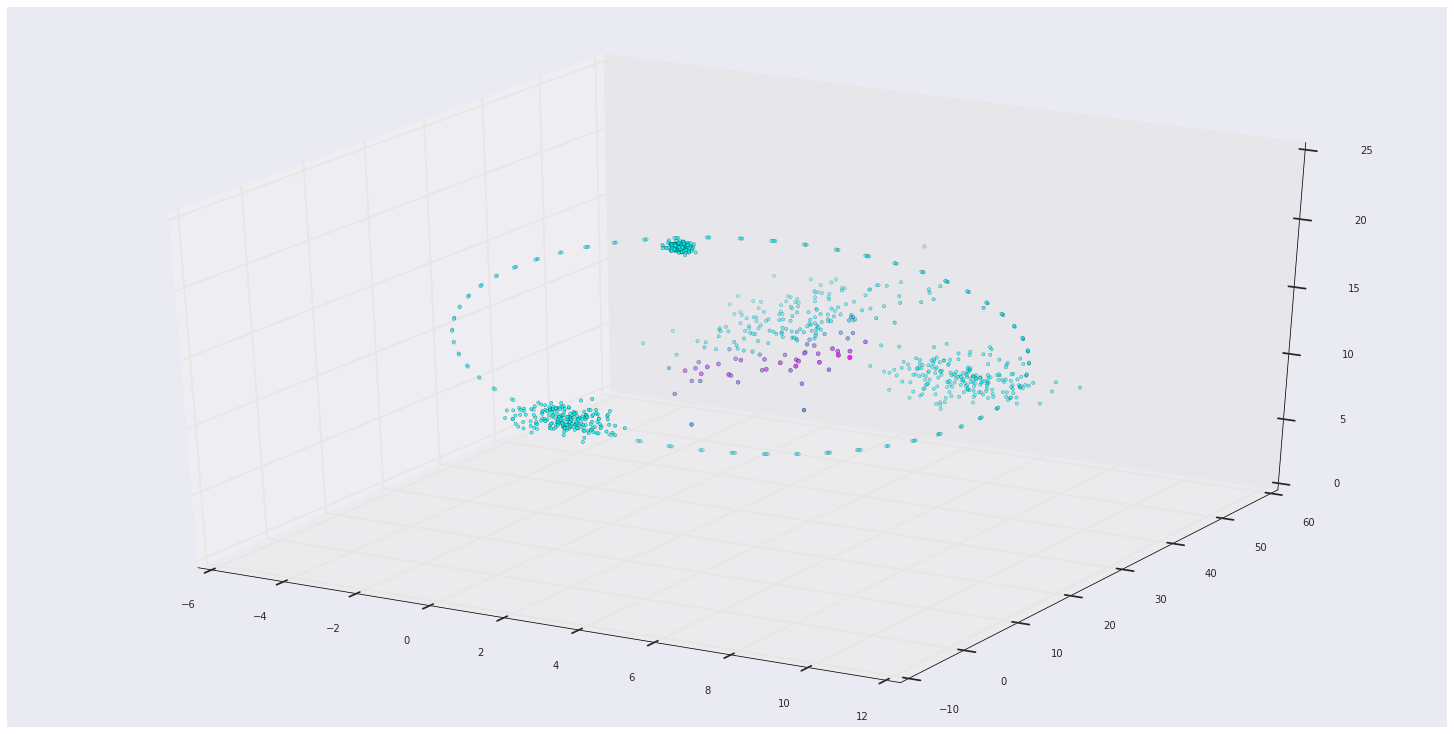

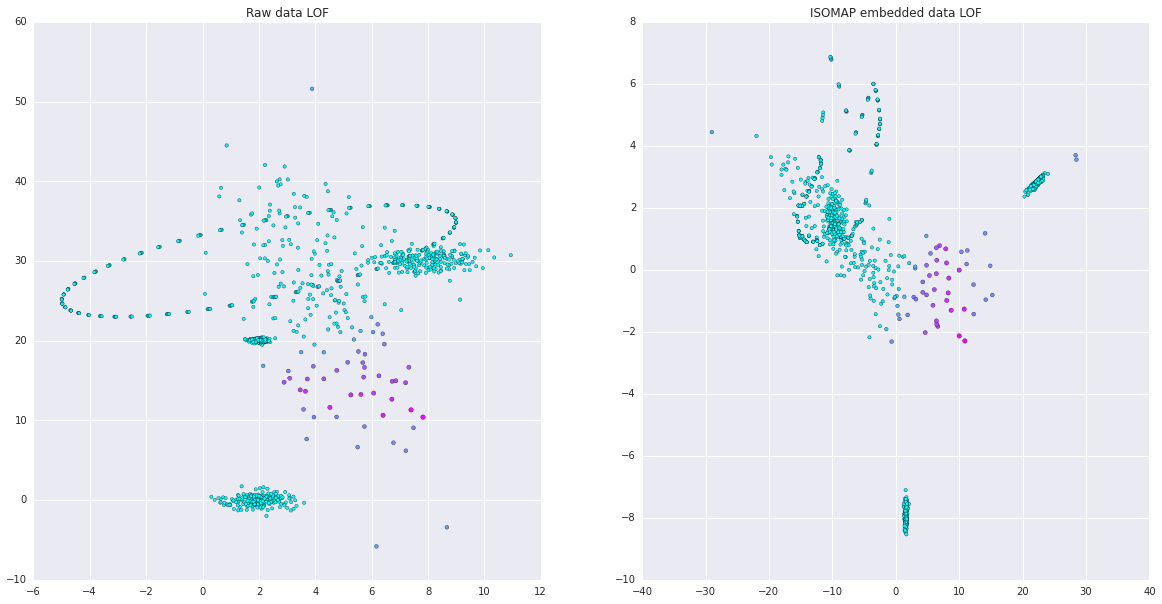

In [20]:
iso = manifold.Isomap(n_neighbors=130, n_components=2, eigen_solver='auto', tol=0, max_iter=None, path_method='auto', neighbors_algorithm='kd_tree')
y_iso = iso.fit_transform(Y)

score_iso, _ = compute_lof(y_iso, k)
score_iso /= score_iso.max()

plot_3d(Y, (score_iso+1)*10)

figure(figsize=(20,10))
subplot(1, 2, 1)
subplot(1, 2, 1).scatter(Y[:, 0], Y[:, 1], (score_iso+1)*10, c=(score_iso+1)*10, cmap="cool")
t = title("Raw data LOF")
subplot(1, 2, 2).scatter(y_iso[:, 0], y_iso[:, 1], s=(score_iso+1)*10, c=(score_iso+1)*10, cmap='cool')
t = title("ISOMAP embedded data LOF")
show()

### Spectral embedding

It finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian. The graph generated can be considered as a discrete approximation of the low dimensional manifold in the high dimensional space. Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low dimensional space, preserving local distances.

/usr/lib64/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:215: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


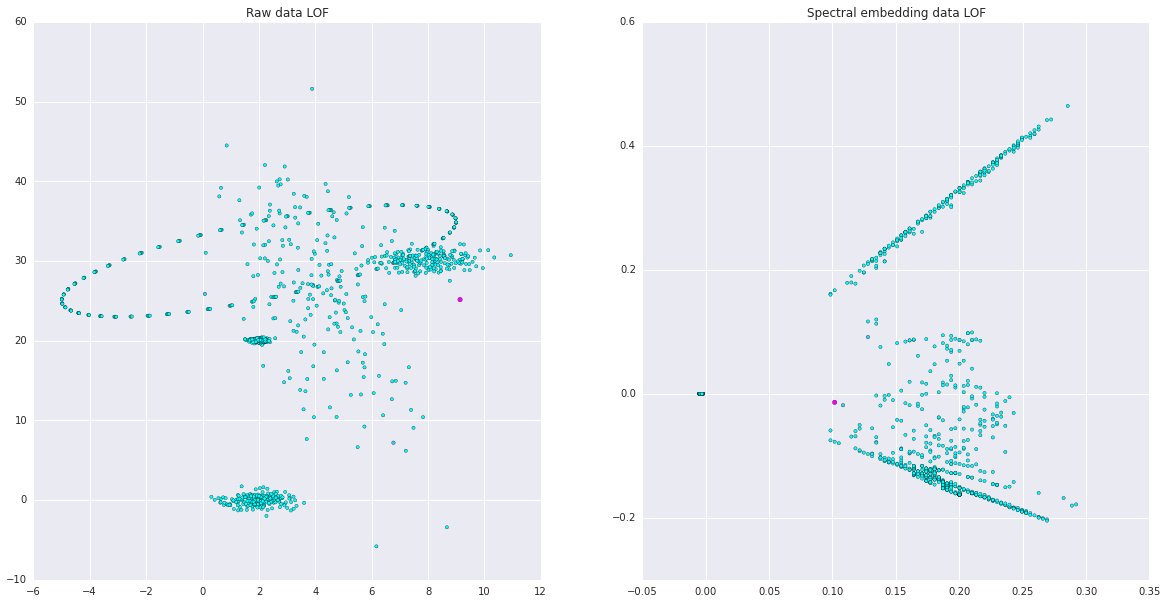

In [21]:
se = manifold.SpectralEmbedding(n_components=2, affinity='nearest_neighbors', gamma=None, random_state=509, n_neighbors=30)
y_se = se.fit_transform(Y)

score_se, _ = compute_lof(y_se, k)
score_se /= score_se.max()

plot_3d(Y, (score_se+1)*10)

figure(figsize=(20,10))
subplot(1, 2, 1)
subplot(1, 2, 1).scatter(Y[:, 0], Y[:, 1], (score_se+1)*10, c=(score_se+1)*10, cmap="cool")
t = title("Raw data LOF")
subplot(1, 2, 2).scatter(y_se[:, 0], y_se[:, 1], s=(score_se+1)*10, c=(score_se+1)*10, cmap='cool')
t = title("Spectral embedding data LOF")
show()

### Multi Dimensional Scaling

It attempts to model similarity or dissimilarity as distances in a geometric space. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

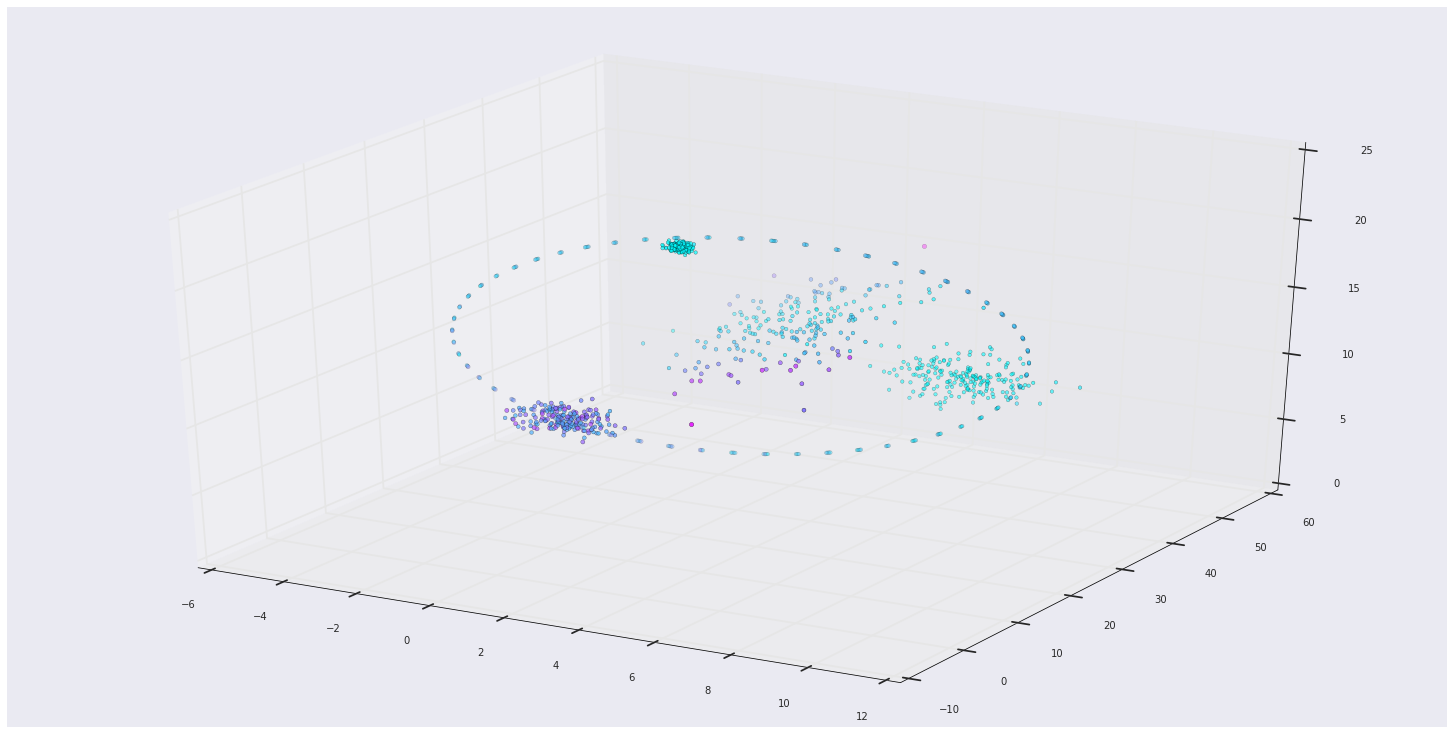

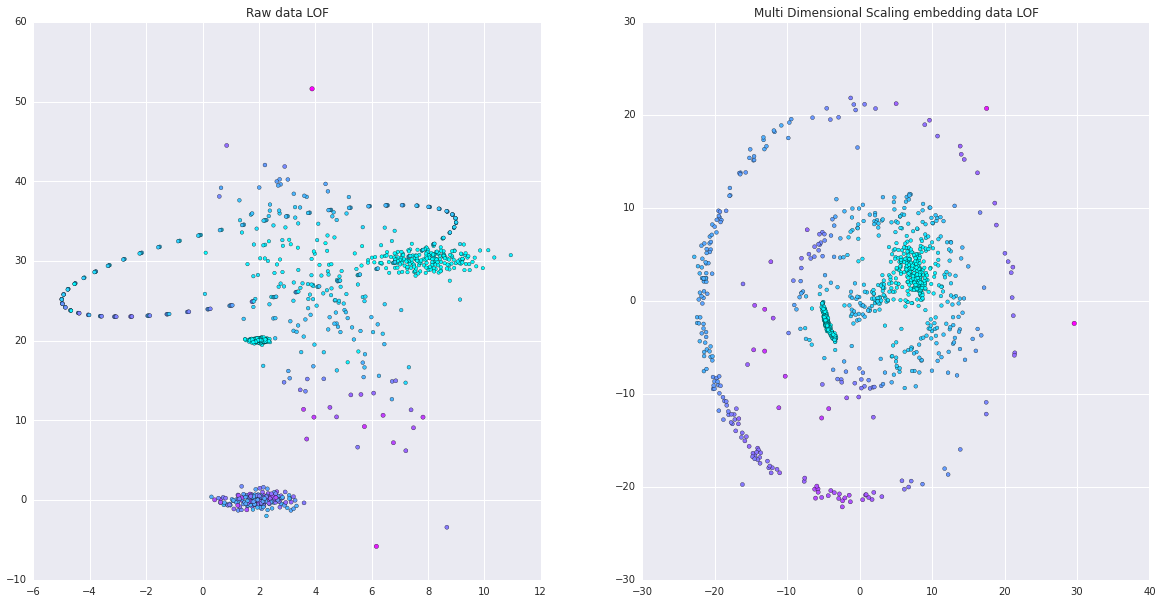

In [22]:
mds = manifold.MDS(n_components=2, metric=True, n_init=40, max_iter=10, verbose=0, eps=0.001, n_jobs=-1, random_state=509, dissimilarity='euclidean')
y_mds = mds.fit_transform(Y)

score_mds, _ = compute_lof(y_mds, k)
score_mds /= score_mds.max()

plot_3d(Y, (score_mds+1)*10)

figure(figsize=(20,10))
subplot(1, 2, 1)
subplot(1, 2, 1).scatter(Y[:, 0], Y[:, 1], (score_mds+1)*10, c=(score_mds+1)*10, cmap="cool")
t = title("Raw data LOF")
subplot(1, 2, 2).scatter(y_mds[:, 0], y_mds[:, 1], s=(score_mds+1)*10, c=(score_mds+1)*10, cmap='cool')
t = title("Multi Dimensional Scaling embedding data LOF")
show()

### Locally linear embedding

Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.

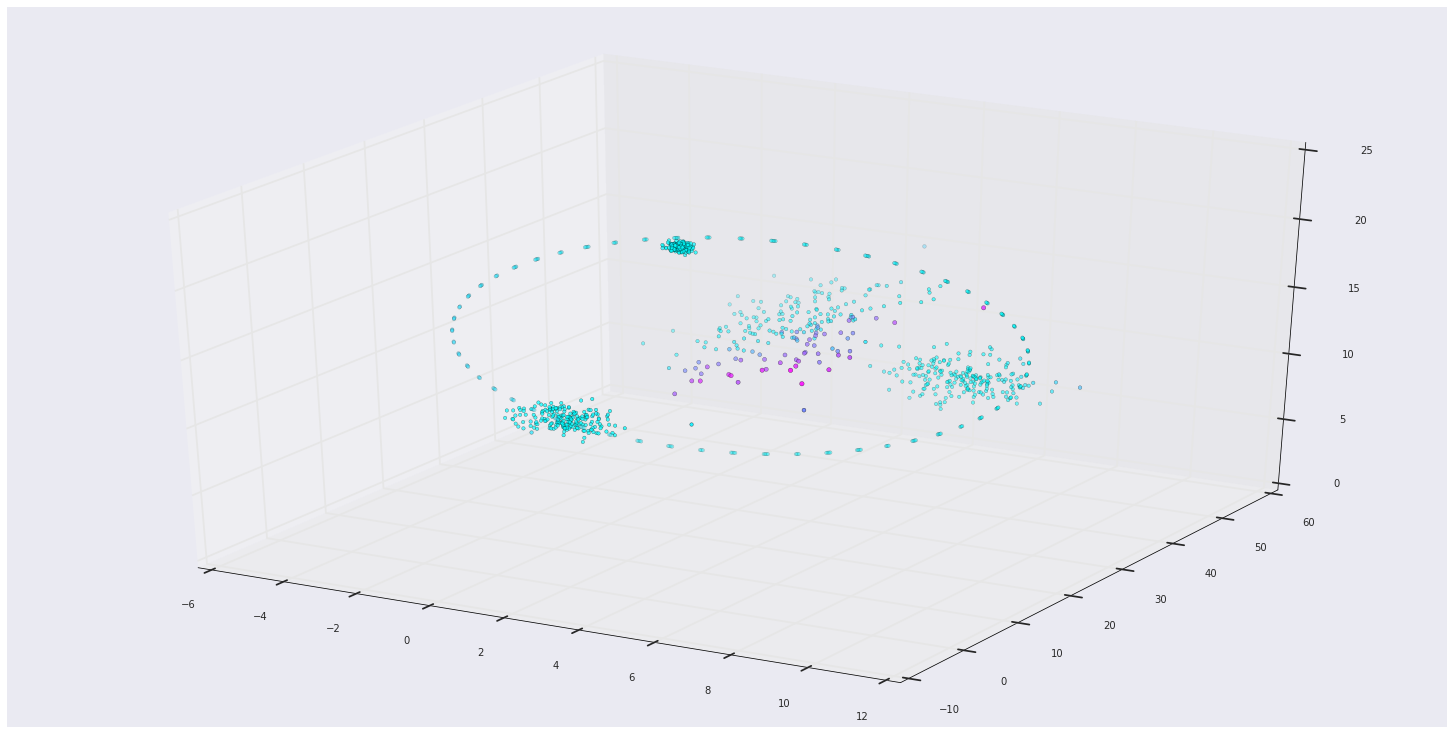

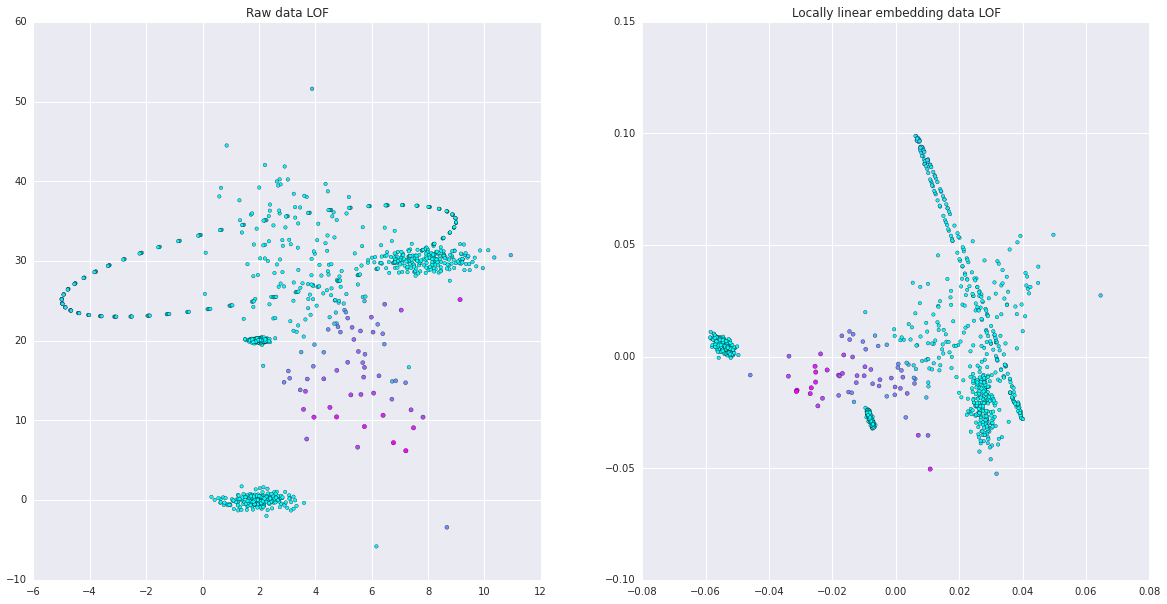

In [23]:
lle = manifold.LocallyLinearEmbedding(n_neighbors=200, n_components=2, reg=0.001, eigen_solver='auto', tol=1e-06, max_iter=100, method='standard', hessian_tol=0.0001, modified_tol=1e-12, neighbors_algorithm='auto', random_state=509)
y_lle = lle.fit_transform(Y)

score_lle, _ = compute_lof(y_lle, k)
score_lle /= score_lle.max()

plot_3d(Y, (score_lle+1)*10)

figure(figsize=(20,10))
subplot(1, 2, 1)
subplot(1, 2, 1).scatter(Y[:, 0], Y[:, 1], (score_lle+1)*10, c=(score_lle+1)*10, cmap="cool")
t = title("Raw data LOF")
subplot(1, 2, 2).scatter(y_lle[:, 0], y_lle[:, 1], s=(score_lle+1)*10, c=(score_lle+1)*10, cmap='cool')
t = title("Locally linear embedding data LOF")
show()

### t-SNE

It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [24]:
y_tsne = calc_tsne(Y, NO_DIMS=2)

Performing PCA
Writing data.dat
Dimension of projection : 2 
Perplexity : 30 
Landmarks(ratio) : 1.000000
Platform detected : linux2
Calling executable "./tSNE_linux"
Reading result.dat
Reordering results


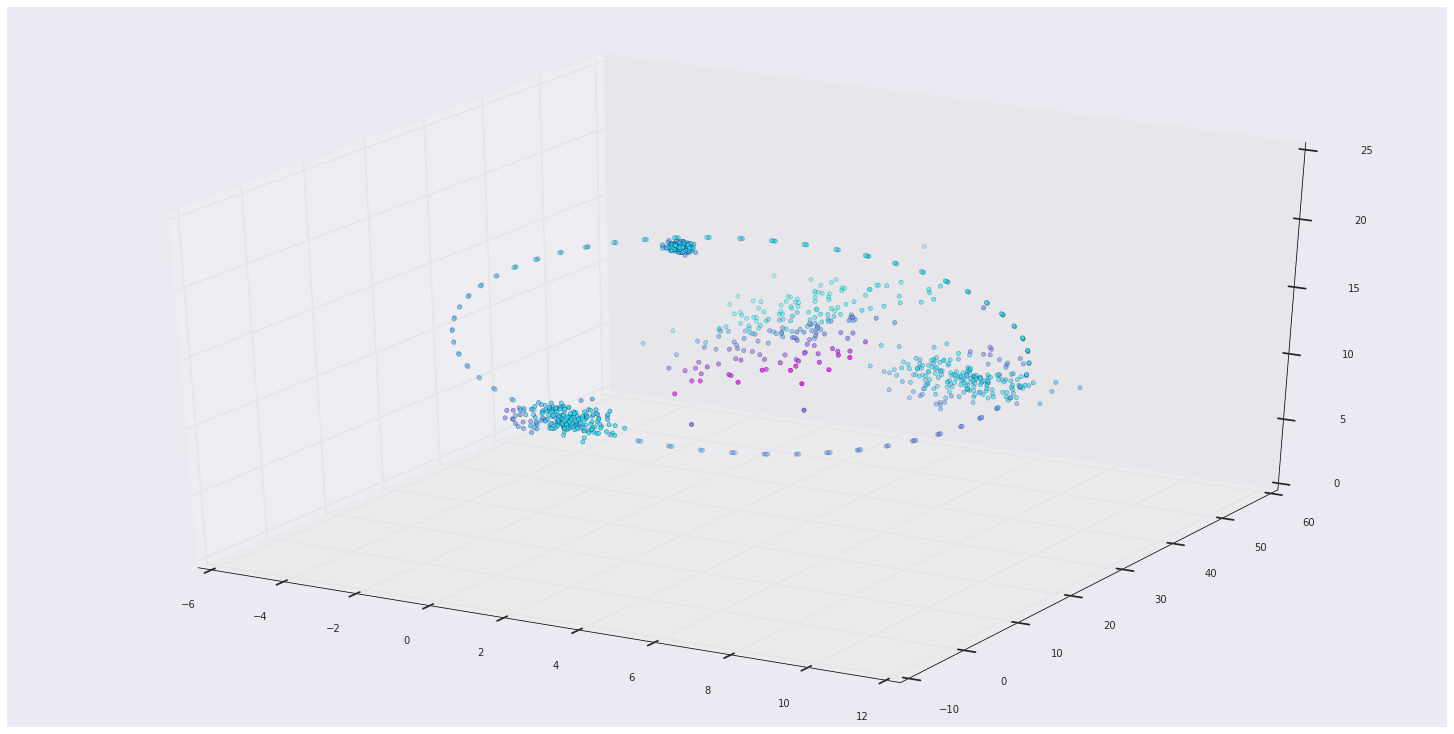

In [25]:
score_tsne, _ = compute_lof(y_tsne, k)
score_tsne /= score_tsne.max()

plot_3d(Y, (score_tsne+1)*10)

figure(figsize=(20,10))
subplot(1, 2, 1)
subplot(1, 2, 1).scatter(Y[:, 0], Y[:, 1], (score_tsne+1)*10, c=(score_tsne+1)*10, cmap="cool")
t = title("Raw data LOF")
subplot(1, 2, 2).scatter(y_tsne[:, 0], y_tsne[:, 1], s=(score_tsne+1)*10, c=(score_tsne+1)*10, cmap='cool')
t = title("t-SNE embedding data LOF")
show()


##Bonus

- Compute the first principle component for points (2,2), (4,4) and (6,6).
- What is the variance of the projected data (on the first PC)?
- For the projected data if we represent them in the original 2-d space, what is the reconstruction error?

##Open Question: Parametric vs Non-parametric models

- There are several approaches when defining parametric and non-parametric models. 
    - What do you think the two refer to and how would you define them? 
    - Do you agree with any of the given definitions? Why?